In [ ]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 8.9 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.python.framework import ops

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [ ]:
avg_uu = np.zeros((51, 2))
uu = np.zeros((51,2,50))

for seed in range(1, 51):
  # Iterate over different seeds


  # Set random seed
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  dde.backend.tf.random.set_random_seed(seed)


  # Set hyperparameters
  num_output = 2  # Number of output variables
  num_domain_points = 1000  # Number of points in the domain
  num_adam_iterations = 2000  # Number of Adam iterations
  learning_rate = 1e-3  # Learning rate for Adam
  loss_weights = [1., 1., 1., 1., 1., 1.]  # Loss weights for different terms in the loss function

  # Set physical parameters
  time_min, time_max = 0.0, 1.0  # Normalized time range
  T = dde.Variable(1.0)  # End time
  bh_xygm_params = [[-0.5, -1.0, 0.5], [-0.2, 0.4, 1.0], [0.8, 0.3, 0.5]]  # Parameters for the gravitational field

  x_initial, y_initial = -1., -1.  # Initial condition at t = time_min
  x_boundary, y_boundary = 1., 1.  # Boundary condition at t = time_max
  mass_parameter = 1.  # Mass parameter

  # Define the ordinary differential equation (ODE)
  def ode(time, state):
      x = state[:, 0:1]
      y = state[:, 1:2]
      x_time_derivative = dde.grad.jacobian(x, time) / T
      x_second_time_derivative = dde.grad.jacobian(x_time_derivative, time) / T
      y_time_derivative = dde.grad.jacobian(y, time) / T
      y_second_time_derivative = dde.grad.jacobian(y_time_derivative, time) / T

      ode_x = mass_parameter * x_second_time_derivative
      ode_y = mass_parameter * y_second_time_derivative
      for x_tmp, y_tmp, g_m_tmp in bh_xygm_params:
          ode_x += g_m_tmp * mass_parameter * (x - x_tmp) / ((x - x_tmp) ** 2 + (y - y_tmp) ** 2) ** 1.5
          ode_y += g_m_tmp * mass_parameter * (y - y_tmp) / ((x - x_tmp) ** 2 + (y - y_tmp) ** 2) ** 1.5

      return [ode_x, ode_y]

  # Activation function
  def tanh_activation_function(x, y):
      out=tf.tanh(y)
      return out

  # Initial condition function
  def initial_condition(_, on_initial):
      return on_initial

  def left_boundary_condition(time, on_boundary):
      flag= np.isclose(time[0], time_min)
      return on_boundary * flag

  def right_boundary_condition(time, on_boundary):
      flag= np.isclose(time[0], time_max)
      return on_boundary*flag


  # Define the geometry and boundary conditions
  geometry = dde.geometry.TimeDomain(time_min, time_max)

  initial_condition_x = dde.icbc.DirichletBC(geometry, lambda time: np.array([x_initial]), left_boundary_condition, component=0)
  initial_condition_y = dde.icbc.DirichletBC(geometry, lambda time: np.array([y_initial]), left_boundary_condition, component=1)
  boundary_condition_x = dde.icbc.DirichletBC(geometry, lambda time: np.array([x_boundary]), right_boundary_condition, component=0)
  boundary_condition_y = dde.icbc.DirichletBC(geometry, lambda time: np.array([y_boundary]), right_boundary_condition, component=1)
  data = dde.data.PDE(geometry, ode, [initial_condition_x, initial_condition_y, boundary_condition_x, boundary_condition_y], num_domain=num_domain_points, num_boundary=2)

  # Define the neural network architecture
  neural_network = dde.nn.FNN([1] + [64] * 3 + [num_output], "tanh", "Glorot normal")
  neural_network.apply_output_transform(tanh_activation_function)

  # Callbacks for monitoring training progress
  resampler = dde.callbacks.PDEPointResampler(period=100)
  variable = dde.callbacks.VariableValue(T, period=100)

  # Create and train the model
  model = dde.Model(data, neural_network)
  model.compile("adam", lr=learning_rate, loss_weights=loss_weights, external_trainable_variables=T)
  loss_history, train_state = model.train(display_every=100, iterations=num_adam_iterations, callbacks=[resampler, variable])
  model.compile("L-BFGS", loss_weights=loss_weights, external_trainable_variables=T)
  loss_history, train_state = model.train(display_every=100, callbacks=[resampler, variable])

  # Save the loss history and trained model
  #dde.saveplot(loss_history, train_state, issave=True, isplot=True)
  #model.save(f'saved_model_seed_{seed}')

  # Generate predictions and plot the results
  time_points = np.linspace(time_min, time_max, 51)
  uu[:,:,seed-1] = model.predict(np.array([time_points]).T)

  ops.reset_default_graph()
  model = None
  neural_network = None
  time_points = None
  resampler = None
  variable = None
  ckpts = None
  losshistory = None
  train_state = None
  geometry = None
  initial_condition_x = None
  initial_condition_y = None
  boundary_condition_x = None
  data = None
  boundary_condition_y = None
  data = None
  ode_x = None
  ode_y = None
  del model, neural_network, time_points, resampler, variable, ckpts, losshistory, train_state, geometry, initial_condition_x, initial_condition_y, boundary_condition_x, data, boundary_condition_y, T
  #device = cuda.get_current_device()
  print(seed)


Compiling model...
Building feed-forward neural network...
'build' took 0.112481 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.665854 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.16e-01, 1.11e+01, 1.00e+00, 1.00e+00, 2.09e+00, 1.49e+00]    [6.16e-01, 1.11e+01, 1.00e+00, 1.00e+00, 2.09e+00, 1.49e+00]    []  
0 [1.00e+00]
100       [1.59e-01, 8.36e-01, 1.53e-01, 2.63e-01, 4.66e-01, 1.71e+00]    [1.59e-01, 8.36e-01, 1.53e-01, 2.63e-01, 4.66e-01, 1.71e+00]    []  
100 [9.79e-01]
200       [9.74e-02, 6.94e-01, 8.61e-02, 2.97e-01, 3.74e-01, 1.40e+00]    [9.74e-02, 6.94e-01, 8.61e-02, 2.97e-01, 3.74e-01, 1.40e+00]    []  
200 [1.07e+00]
300       [3.43e-01, 1.47e-01, 3.11e-01, 2.10e-01, 2.07e-01, 7.60e-02]    [3.43e-01, 1.47e-01, 3.11e-01, 2.10e-01, 2.07e-01, 7.60e-02]    []  
300 [1.11e+00]
400       [2.66e-01, 1.03e-01, 2.66e-01, 2.23e-01, 1.39e-01, 2.90e-02]    [2.66e-01, 1.03e-01, 2.66e-01, 2.23e-01, 1.39e-01, 2.90e-02]    []  
400 [1.23e+00]
500       [2.58e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.394988 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.17e+01, 4.29e+01, 1.00e+00, 1.00e+00, 1.07e+00, 7.25e-01]    [1.17e+01, 4.29e+01, 1.00e+00, 1.00e+00, 1.07e+00, 7.25e-01]    []  
0 [1.00e+00]
100       [1.32e-01, 1.02e-01, 7.28e-01, 3.89e-01, 1.11e-01, 3.21e+00]    [1.32e-01, 1.02e-01, 7.28e-01, 3.89e-01, 1.11e-01, 3.21e+00]    []  
100 [9.43e-01]
200       [2.80e-01, 5.63e-01, 3.04e-01, 2.96e-01, 2.58e-01, 2.09e+00]    [2.80e-01, 5.63e-01, 3.04e-01, 2.96e-01, 2.58e-01, 2.09e+00]    []  
200 [9.83e-01]
300       [1.81e-01, 7.44e-01, 1.20e-01, 2.80e-01, 3.80e-01, 1.56e+00]    [1.81e-01, 7.44e-01, 1.20e-01, 2.80e-01, 3.80e-01, 1.56e+00]    []  
300 [1.06e+00]
400       [1.61e-01, 6.19e-01, 1.02e-01, 3.02e-01, 3.40e-01, 1.33e+00]    [1.61e-01, 6.19e-01, 1.02e-01, 3.02e-01, 3.40e-01, 1.33e+00]    []  
400 [1.11e+00]
500       [1.54e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.345310 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.71e+00, 1.33e+01, 1.00e+00, 1.00e+00, 9.99e-01, 1.21e+00]    [1.71e+00, 1.33e+01, 1.00e+00, 1.00e+00, 9.99e-01, 1.21e+00]    []  
0 [1.00e+00]
100       [1.74e-01, 9.69e-01, 1.61e-01, 2.47e-01, 4.10e-01, 1.58e+00]    [1.74e-01, 9.69e-01, 1.61e-01, 2.47e-01, 4.10e-01, 1.58e+00]    []  
100 [1.01e+00]
200       [7.47e-02, 4.08e-01, 1.80e-01, 3.77e-01, 3.36e-01, 8.89e-01]    [7.47e-02, 4.08e-01, 1.80e-01, 3.77e-01, 3.36e-01, 8.89e-01]    []  
200 [1.06e+00]
300       [2.09e-01, 8.69e-02, 3.36e-01, 3.27e-01, 1.90e-01, 4.35e-02]    [2.09e-01, 8.69e-02, 3.36e-01, 3.27e-01, 1.90e-01, 4.35e-02]    []  
300 [1.11e+00]
400       [2.16e-01, 6.62e-02, 2.56e-01, 2.83e-01, 1.72e-01, 3.57e-02]    [2.16e-01, 6.62e-02, 2.56e-01, 2.83e-01, 1.72e-01, 3.57e-02]    []  
400 [1.22e+00]
500       [2.29e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.394998 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.77e-01, 6.25e+00, 1.00e+00, 1.00e+00, 6.43e-01, 1.70e+00]    [9.77e-01, 6.25e+00, 1.00e+00, 1.00e+00, 6.43e-01, 1.70e+00]    []  
0 [1.00e+00]
100       [1.74e-01, 6.96e-01, 9.18e-02, 2.79e-01, 4.04e-01, 1.52e+00]    [1.74e-01, 6.96e-01, 9.18e-02, 2.79e-01, 4.04e-01, 1.52e+00]    []  
100 [1.03e+00]
200       [3.48e-01, 8.27e-02, 2.88e-01, 2.53e-01, 2.28e-01, 9.33e-02]    [3.48e-01, 8.27e-02, 2.88e-01, 2.53e-01, 2.28e-01, 9.33e-02]    []  
200 [1.08e+00]
300       [2.51e-01, 7.32e-02, 2.53e-01, 2.63e-01, 1.83e-01, 4.68e-02]    [2.51e-01, 7.32e-02, 2.53e-01, 2.63e-01, 1.83e-01, 4.68e-02]    []  
300 [1.18e+00]
400       [2.45e-01, 5.65e-02, 1.41e-01, 2.00e-01, 1.80e-01, 5.52e-02]    [2.45e-01, 5.65e-02, 1.41e-01, 2.00e-01, 1.80e-01, 5.52e-02]    []  
400 [1.27e+00]
500       [2.25e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.392720 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.20e+00, 1.10e+02, 1.00e+00, 1.00e+00, 1.65e+00, 6.93e-01]    [5.20e+00, 1.10e+02, 1.00e+00, 1.00e+00, 1.65e+00, 6.93e-01]    []  
0 [1.00e+00]
100       [5.81e-02, 4.66e-01, 1.19e+00, 5.72e-01, 1.58e-01, 2.96e+00]    [5.81e-02, 4.66e-01, 1.19e+00, 5.72e-01, 1.58e-01, 2.96e+00]    []  
100 [9.55e-01]
200       [6.09e-02, 1.42e-01, 8.41e-01, 4.85e-01, 1.50e-01, 3.13e+00]    [6.09e-02, 1.42e-01, 8.41e-01, 4.85e-01, 1.50e-01, 3.13e+00]    []  
200 [8.80e-01]
300       [1.92e-01, 1.65e-01, 3.83e-01, 4.05e-01, 3.07e-01, 2.77e+00]    [1.92e-01, 1.65e-01, 3.83e-01, 4.05e-01, 3.07e-01, 2.77e+00]    []  
300 [8.52e-01]
400       [1.16e-01, 5.44e-01, 1.08e-01, 3.02e-01, 6.36e-01, 1.87e+00]    [1.16e-01, 5.44e-01, 1.08e-01, 3.02e-01, 6.36e-01, 1.87e+00]    []  
400 [9.04e-01]
500       [1.18e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.348877 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.26e-01, 8.24e+00, 1.00e+00, 1.00e+00, 1.79e+00, 1.69e+00]    [4.26e-01, 8.24e+00, 1.00e+00, 1.00e+00, 1.79e+00, 1.69e+00]    []  
0 [1.00e+00]
100       [9.56e-02, 5.70e-01, 2.46e-01, 3.22e-01, 3.38e-01, 1.15e+00]    [9.56e-02, 5.70e-01, 2.46e-01, 3.22e-01, 3.38e-01, 1.15e+00]    []  
100 [9.83e-01]
200       [2.04e-01, 1.63e-01, 4.21e-01, 3.14e-01, 2.25e-01, 5.83e-02]    [2.04e-01, 1.63e-01, 4.21e-01, 3.14e-01, 2.25e-01, 5.83e-02]    []  
200 [1.02e+00]
300       [2.08e-01, 1.01e-01, 3.19e-01, 3.13e-01, 1.90e-01, 4.30e-02]    [2.08e-01, 1.01e-01, 3.19e-01, 3.13e-01, 1.90e-01, 4.30e-02]    []  
300 [1.12e+00]
400       [1.99e-01, 6.70e-02, 2.00e-01, 2.46e-01, 1.98e-01, 5.45e-02]    [1.99e-01, 6.70e-02, 2.00e-01, 2.46e-01, 1.98e-01, 5.45e-02]    []  
400 [1.21e+00]
500       [1.58e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.346801 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.24e+01, 2.00e+01, 1.00e+00, 1.00e+00, 7.74e-01, 6.53e-01]    [1.24e+01, 2.00e+01, 1.00e+00, 1.00e+00, 7.74e-01, 6.53e-01]    []  
0 [1.00e+00]
100       [2.46e-01, 2.90e-01, 5.82e-01, 3.01e-01, 1.28e-01, 2.87e+00]    [2.46e-01, 2.90e-01, 5.82e-01, 3.01e-01, 1.28e-01, 2.87e+00]    []  
100 [9.46e-01]
200       [2.19e-01, 6.77e-01, 9.04e-02, 2.92e-01, 3.98e-01, 1.56e+00]    [2.19e-01, 6.77e-01, 9.04e-02, 2.92e-01, 3.98e-01, 1.56e+00]    []  
200 [1.05e+00]
300       [2.54e-01, 2.24e-01, 6.97e-02, 1.82e-01, 3.53e-01, 8.67e-01]    [2.54e-01, 2.24e-01, 6.97e-02, 1.82e-01, 3.53e-01, 8.67e-01]    []  
300 [1.07e+00]
400       [3.55e-01, 1.43e-01, 1.14e-01, 1.79e-01, 2.56e-01, 1.48e-01]    [3.55e-01, 1.43e-01, 1.14e-01, 1.79e-01, 2.56e-01, 1.48e-01]    []  
400 [1.13e+00]
500       [1.83e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.562178 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.49e-01, 3.52e+00, 1.00e+00, 1.00e+00, 3.26e-01, 2.18e+00]    [5.49e-01, 3.52e+00, 1.00e+00, 1.00e+00, 3.26e-01, 2.18e+00]    []  
0 [1.00e+00]
100       [3.38e-01, 1.50e-01, 4.96e-01, 3.83e-01, 1.70e-01, 4.35e-02]    [3.38e-01, 1.50e-01, 4.96e-01, 3.83e-01, 1.70e-01, 4.35e-02]    []  
100 [9.63e-01]
200       [2.13e-01, 1.11e-01, 3.82e-01, 3.29e-01, 1.87e-01, 4.75e-02]    [2.13e-01, 1.11e-01, 3.82e-01, 3.29e-01, 1.87e-01, 4.75e-02]    []  
200 [1.05e+00]
300       [2.39e-01, 7.06e-02, 2.80e-01, 2.62e-01, 1.83e-01, 4.96e-02]    [2.39e-01, 7.06e-02, 2.80e-01, 2.62e-01, 1.83e-01, 4.96e-02]    []  
300 [1.14e+00]
400       [2.58e-01, 5.83e-02, 1.79e-01, 2.24e-01, 1.82e-01, 5.44e-02]    [2.58e-01, 5.83e-02, 1.79e-01, 2.24e-01, 1.82e-01, 5.44e-02]    []  
400 [1.23e+00]
500       [2.33e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.367476 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.93e+00, 1.97e+01, 1.00e+00, 1.00e+00, 8.36e-01, 8.06e-01]    [6.93e+00, 1.97e+01, 1.00e+00, 1.00e+00, 8.36e-01, 8.06e-01]    []  
0 [1.00e+00]
100       [3.14e-01, 5.33e-01, 4.66e-01, 2.86e-01, 1.41e-01, 2.37e+00]    [3.14e-01, 5.33e-01, 4.66e-01, 2.86e-01, 1.41e-01, 2.37e+00]    []  
100 [9.78e-01]
200       [2.40e-01, 4.45e-01, 1.82e-01, 3.44e-01, 3.15e-01, 1.14e+00]    [2.40e-01, 4.45e-01, 1.82e-01, 3.44e-01, 3.15e-01, 1.14e+00]    []  
200 [1.03e+00]
300       [4.38e-01, 1.80e-01, 1.60e-01, 1.91e-01, 2.99e-01, 2.31e-01]    [4.38e-01, 1.80e-01, 1.60e-01, 1.91e-01, 2.99e-01, 2.31e-01]    []  
300 [1.04e+00]
400       [2.61e-01, 9.74e-02, 2.01e-01, 2.17e-01, 1.85e-01, 5.09e-02]    [2.61e-01, 9.74e-02, 2.01e-01, 2.17e-01, 1.85e-01, 5.09e-02]    []  
400 [1.22e+00]
500       [2.36e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.557847 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.89e-01, 1.14e+01, 1.00e+00, 1.00e+00, 1.18e+00, 1.39e+00]    [9.89e-01, 1.14e+01, 1.00e+00, 1.00e+00, 1.18e+00, 1.39e+00]    []  
0 [1.00e+00]
100       [1.69e-01, 7.29e-01, 2.10e-01, 2.72e-01, 3.51e-01, 1.55e+00]    [1.69e-01, 7.29e-01, 2.10e-01, 2.72e-01, 3.51e-01, 1.55e+00]    []  
100 [1.01e+00]
200       [5.00e-01, 1.58e-01, 2.76e-01, 3.19e-01, 2.36e-01, 1.46e-01]    [5.00e-01, 1.58e-01, 2.76e-01, 3.19e-01, 2.36e-01, 1.46e-01]    []  
200 [9.74e-01]
300       [2.20e-01, 9.35e-02, 3.51e-01, 3.29e-01, 1.90e-01, 4.64e-02]    [2.20e-01, 9.35e-02, 3.51e-01, 3.29e-01, 1.90e-01, 4.64e-02]    []  
300 [1.09e+00]
400       [2.18e-01, 7.64e-02, 2.86e-01, 3.11e-01, 1.75e-01, 3.58e-02]    [2.18e-01, 7.64e-02, 2.86e-01, 3.11e-01, 1.75e-01, 3.58e-02]    []  
400 [1.18e+00]
500       [2.25e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.383597 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.10e+00, 1.02e+01, 1.00e+00, 1.00e+00, 5.69e-01, 8.90e-01]    [3.10e+00, 1.02e+01, 1.00e+00, 1.00e+00, 5.69e-01, 8.90e-01]    []  
0 [1.00e+00]
100       [2.17e-01, 5.94e-01, 4.10e-01, 2.20e-01, 3.00e-01, 1.19e+00]    [2.17e-01, 5.94e-01, 4.10e-01, 2.20e-01, 3.00e-01, 1.19e+00]    []  
100 [9.96e-01]
200       [1.95e-01, 8.04e-02, 3.77e-01, 3.64e-01, 2.21e-01, 6.68e-02]    [1.95e-01, 8.04e-02, 3.77e-01, 3.64e-01, 2.21e-01, 6.68e-02]    []  
200 [9.97e-01]
300       [1.96e-01, 5.90e-02, 3.03e-01, 3.29e-01, 2.10e-01, 5.90e-02]    [1.96e-01, 5.90e-02, 3.03e-01, 3.29e-01, 2.10e-01, 5.90e-02]    []  
300 [1.09e+00]
400       [2.00e-01, 4.84e-02, 2.33e-01, 2.85e-01, 2.03e-01, 5.64e-02]    [2.00e-01, 4.84e-02, 2.33e-01, 2.85e-01, 2.03e-01, 5.64e-02]    []  
400 [1.17e+00]
500       [2.15e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.362969 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.26e+00, 1.48e+01, 1.00e+00, 1.00e+00, 6.74e-01, 6.81e-01]    [8.26e+00, 1.48e+01, 1.00e+00, 1.00e+00, 6.74e-01, 6.81e-01]    []  
0 [1.00e+00]
100       [4.12e-01, 5.51e-01, 4.93e-01, 1.90e-01, 1.55e-01, 1.58e+00]    [4.12e-01, 5.51e-01, 4.93e-01, 1.90e-01, 1.55e-01, 1.58e+00]    []  
100 [9.96e-01]
200       [3.04e-01, 2.51e-01, 3.39e-01, 3.49e-01, 3.09e-01, 2.92e-01]    [3.04e-01, 2.51e-01, 3.39e-01, 3.49e-01, 3.09e-01, 2.92e-01]    []  
200 [9.00e-01]
300       [1.98e-01, 9.33e-02, 3.70e-01, 3.42e-01, 2.27e-01, 7.09e-02]    [1.98e-01, 9.33e-02, 3.70e-01, 3.42e-01, 2.27e-01, 7.09e-02]    []  
300 [1.00e+00]
400       [2.03e-01, 6.74e-02, 2.89e-01, 2.99e-01, 2.08e-01, 5.81e-02]    [2.03e-01, 6.74e-02, 2.89e-01, 2.99e-01, 2.08e-01, 5.81e-02]    []  
400 [1.11e+00]
500       [2.14e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.673036 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.53e+00, 9.29e+00, 1.00e+00, 1.00e+00, 7.66e-01, 1.33e+00]    [1.53e+00, 9.29e+00, 1.00e+00, 1.00e+00, 7.66e-01, 1.33e+00]    []  
0 [1.00e+00]
100       [1.85e-01, 6.43e-01, 2.49e-01, 2.70e-01, 3.07e-01, 1.43e+00]    [1.85e-01, 6.43e-01, 2.49e-01, 2.70e-01, 3.07e-01, 1.43e+00]    []  
100 [1.01e+00]
200       [2.13e-01, 1.11e-01, 4.15e-01, 3.03e-01, 2.00e-01, 5.71e-02]    [2.13e-01, 1.11e-01, 4.15e-01, 3.03e-01, 2.00e-01, 5.71e-02]    []  
200 [1.03e+00]
300       [2.43e-01, 6.64e-02, 2.82e-01, 2.52e-01, 1.72e-01, 5.01e-02]    [2.43e-01, 6.64e-02, 2.82e-01, 2.52e-01, 1.72e-01, 5.01e-02]    []  
300 [1.13e+00]
400       [2.57e-01, 5.92e-02, 1.61e-01, 2.11e-01, 1.72e-01, 5.54e-02]    [2.57e-01, 5.92e-02, 1.61e-01, 2.11e-01, 1.72e-01, 5.54e-02]    []  
400 [1.22e+00]
500       [2.30e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.417184 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.04e+01, 4.58e+01, 1.00e+00, 1.00e+00, 9.48e-01, 4.88e-01]    [6.04e+01, 4.58e+01, 1.00e+00, 1.00e+00, 9.48e-01, 4.88e-01]    []  
0 [1.00e+00]
100       [4.20e-02, 1.42e-01, 1.05e+00, 4.18e-01, 9.38e-02, 3.18e+00]    [4.20e-02, 1.42e-01, 1.05e+00, 4.18e-01, 9.38e-02, 3.18e+00]    []  
100 [9.23e-01]
200       [2.09e-01, 2.77e-01, 6.82e-01, 3.09e-01, 1.34e-01, 2.79e+00]    [2.09e-01, 2.77e-01, 6.82e-01, 3.09e-01, 1.34e-01, 2.79e+00]    []  
200 [8.80e-01]
300       [3.65e-01, 4.93e-01, 4.11e-01, 2.76e-01, 2.24e-01, 1.51e+00]    [3.65e-01, 4.93e-01, 4.11e-01, 2.76e-01, 2.24e-01, 1.51e+00]    []  
300 [9.30e-01]
400       [2.42e-01, 2.53e-01, 1.97e-01, 2.79e-01, 3.63e-01, 9.14e-01]    [2.42e-01, 2.53e-01, 1.97e-01, 2.79e-01, 3.63e-01, 9.14e-01]    []  
400 [8.99e-01]
500       [2.63e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.490505 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.43e+00, 8.01e+00, 1.00e+00, 1.00e+00, 6.15e-01, 1.34e+00]    [1.43e+00, 8.01e+00, 1.00e+00, 1.00e+00, 6.15e-01, 1.34e+00]    []  
0 [1.00e+00]
100       [1.90e-01, 4.02e-01, 2.60e-01, 3.52e-01, 2.97e-01, 1.13e+00]    [1.90e-01, 4.02e-01, 2.60e-01, 3.52e-01, 2.97e-01, 1.13e+00]    []  
100 [9.99e-01]
200       [2.51e-01, 9.90e-02, 3.51e-01, 2.70e-01, 2.33e-01, 8.17e-02]    [2.51e-01, 9.90e-02, 3.51e-01, 2.70e-01, 2.33e-01, 8.17e-02]    []  
200 [1.02e+00]
300       [2.36e-01, 5.95e-02, 2.35e-01, 2.43e-01, 2.09e-01, 6.94e-02]    [2.36e-01, 5.95e-02, 2.35e-01, 2.43e-01, 2.09e-01, 6.94e-02]    []  
300 [1.13e+00]
400       [2.30e-01, 5.23e-02, 1.31e-01, 2.05e-01, 2.09e-01, 7.33e-02]    [2.30e-01, 5.23e-02, 1.31e-01, 2.05e-01, 2.09e-01, 7.33e-02]    []  
400 [1.23e+00]
500       [1.99e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.392705 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.12e+00, 1.34e+01, 1.00e+00, 1.00e+00, 1.19e+00, 1.29e+00]    [1.12e+00, 1.34e+01, 1.00e+00, 1.00e+00, 1.19e+00, 1.29e+00]    []  
0 [1.00e+00]
100       [1.91e-01, 1.02e+00, 2.21e-01, 2.26e-01, 3.63e-01, 1.51e+00]    [1.91e-01, 1.02e+00, 2.21e-01, 2.26e-01, 3.63e-01, 1.51e+00]    []  
100 [1.00e+00]
200       [1.17e-01, 4.60e-01, 1.88e-01, 3.56e-01, 3.47e-01, 6.31e-01]    [1.17e-01, 4.60e-01, 1.88e-01, 3.56e-01, 3.47e-01, 6.31e-01]    []  
200 [1.02e+00]
300       [2.28e-01, 1.03e-01, 3.18e-01, 2.89e-01, 1.92e-01, 4.57e-02]    [2.28e-01, 1.03e-01, 3.18e-01, 2.89e-01, 1.92e-01, 4.57e-02]    []  
300 [1.13e+00]
400       [2.33e-01, 7.56e-02, 1.87e-01, 2.24e-01, 1.85e-01, 4.85e-02]    [2.33e-01, 7.56e-02, 1.87e-01, 2.24e-01, 1.85e-01, 4.85e-02]    []  
400 [1.24e+00]
500       [1.99e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.443762 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.21e+00, 3.38e+01, 1.00e+00, 1.00e+00, 1.53e+00, 9.81e-01]    [1.21e+00, 3.38e+01, 1.00e+00, 1.00e+00, 1.53e+00, 9.81e-01]    []  
0 [1.00e+00]
100       [9.43e-02, 1.45e-01, 7.50e-01, 4.34e-01, 1.01e-01, 3.21e+00]    [9.43e-02, 1.45e-01, 7.50e-01, 4.34e-01, 1.01e-01, 3.21e+00]    []  
100 [1.00e+00]
200       [1.57e-01, 6.74e-01, 1.01e-01, 2.99e-01, 4.29e-01, 1.65e+00]    [1.57e-01, 6.74e-01, 1.01e-01, 2.99e-01, 4.29e-01, 1.65e+00]    []  
200 [1.03e+00]
300       [1.06e-01, 5.34e-01, 1.43e-01, 3.15e-01, 3.52e-01, 1.08e+00]    [1.06e-01, 5.34e-01, 1.43e-01, 3.15e-01, 3.52e-01, 1.08e+00]    []  
300 [1.07e+00]
400       [4.54e-01, 2.46e-01, 2.62e-01, 2.07e-01, 2.13e-01, 8.30e-02]    [4.54e-01, 2.46e-01, 2.62e-01, 2.07e-01, 2.13e-01, 8.30e-02]    []  
400 [1.10e+00]
500       [2.36e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.372086 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.79e-01, 6.13e+00, 1.00e+00, 1.00e+00, 5.49e-01, 1.63e+00]    [9.79e-01, 6.13e+00, 1.00e+00, 1.00e+00, 5.49e-01, 1.63e+00]    []  
0 [1.00e+00]
100       [1.71e-01, 4.56e-01, 2.42e-01, 3.50e-01, 3.31e-01, 5.86e-01]    [1.71e-01, 4.56e-01, 2.42e-01, 3.50e-01, 3.31e-01, 5.86e-01]    []  
100 [9.92e-01]
200       [2.35e-01, 8.05e-02, 3.32e-01, 2.85e-01, 2.01e-01, 6.27e-02]    [2.35e-01, 8.05e-02, 3.32e-01, 2.85e-01, 2.01e-01, 6.27e-02]    []  
200 [1.05e+00]
300       [2.53e-01, 5.91e-02, 2.23e-01, 2.31e-01, 1.89e-01, 6.28e-02]    [2.53e-01, 5.91e-02, 2.23e-01, 2.31e-01, 1.89e-01, 6.28e-02]    []  
300 [1.14e+00]
400       [2.35e-01, 5.75e-02, 1.38e-01, 2.00e-01, 1.91e-01, 6.37e-02]    [2.35e-01, 5.75e-02, 1.38e-01, 2.00e-01, 1.91e-01, 6.37e-02]    []  
400 [1.23e+00]
500       [1.09e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.404150 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.53e-01, 6.40e+00, 1.00e+00, 1.00e+00, 2.54e-01, 1.19e+00]    [9.53e-01, 6.40e+00, 1.00e+00, 1.00e+00, 2.54e-01, 1.19e+00]    []  
0 [1.00e+00]
100       [1.73e-01, 4.19e-01, 1.78e-01, 2.82e-01, 3.58e-01, 6.35e-01]    [1.73e-01, 4.19e-01, 1.78e-01, 2.82e-01, 3.58e-01, 6.35e-01]    []  
100 [9.78e-01]
200       [2.46e-01, 1.08e-01, 2.98e-01, 2.43e-01, 2.12e-01, 7.23e-02]    [2.46e-01, 1.08e-01, 2.98e-01, 2.43e-01, 2.12e-01, 7.23e-02]    []  
200 [1.07e+00]
300       [2.34e-01, 6.59e-02, 1.81e-01, 2.26e-01, 2.11e-01, 7.40e-02]    [2.34e-01, 6.59e-02, 1.81e-01, 2.26e-01, 2.11e-01, 7.40e-02]    []  
300 [1.16e+00]
400       [1.38e-01, 4.85e-02, 9.59e-02, 1.71e-01, 2.37e-01, 9.14e-02]    [1.38e-01, 4.85e-02, 9.59e-02, 1.71e-01, 2.37e-01, 9.14e-02]    []  
400 [1.25e+00]
500       [9.78e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.426816 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.22e+00, 8.56e+00, 1.00e+00, 1.00e+00, 4.58e-01, 9.32e-01]    [2.22e+00, 8.56e+00, 1.00e+00, 1.00e+00, 4.58e-01, 9.32e-01]    []  
0 [1.00e+00]
100       [1.05e-01, 5.61e-01, 2.94e-01, 2.64e-01, 3.23e-01, 1.18e+00]    [1.05e-01, 5.61e-01, 2.94e-01, 2.64e-01, 3.23e-01, 1.18e+00]    []  
100 [9.90e-01]
200       [2.21e-01, 1.14e-01, 3.85e-01, 2.88e-01, 2.14e-01, 6.84e-02]    [2.21e-01, 1.14e-01, 3.85e-01, 2.88e-01, 2.14e-01, 6.84e-02]    []  
200 [1.01e+00]
300       [2.43e-01, 6.56e-02, 2.78e-01, 2.63e-01, 1.98e-01, 6.06e-02]    [2.43e-01, 6.56e-02, 2.78e-01, 2.63e-01, 1.98e-01, 6.06e-02]    []  
300 [1.11e+00]
400       [2.36e-01, 5.34e-02, 1.98e-01, 2.49e-01, 1.92e-01, 5.62e-02]    [2.36e-01, 5.34e-02, 1.98e-01, 2.49e-01, 1.92e-01, 5.62e-02]    []  
400 [1.20e+00]
500       [2.22e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.368510 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.22e+00, 2.17e+01, 1.00e+00, 1.00e+00, 1.06e+00, 9.82e-01]    [3.22e+00, 2.17e+01, 1.00e+00, 1.00e+00, 1.06e+00, 9.82e-01]    []  
0 [1.00e+00]
100       [2.78e-01, 3.46e-01, 4.63e-01, 3.20e-01, 1.52e-01, 2.69e+00]    [2.78e-01, 3.46e-01, 4.63e-01, 3.20e-01, 1.52e-01, 2.69e+00]    []  
100 [9.71e-01]
200       [1.48e-01, 6.44e-01, 9.90e-02, 2.96e-01, 3.89e-01, 1.44e+00]    [1.48e-01, 6.44e-01, 9.90e-02, 2.96e-01, 3.89e-01, 1.44e+00]    []  
200 [1.05e+00]
300       [2.68e-01, 2.88e-01, 1.56e-01, 2.79e-01, 3.39e-01, 4.95e-01]    [2.68e-01, 2.88e-01, 1.56e-01, 2.79e-01, 3.39e-01, 4.95e-01]    []  
300 [1.04e+00]
400       [2.64e-01, 7.44e-02, 2.07e-01, 2.18e-01, 1.78e-01, 5.55e-02]    [2.64e-01, 7.44e-02, 2.07e-01, 2.18e-01, 1.78e-01, 5.55e-02]    []  
400 [1.19e+00]
500       [2.27e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.906076 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.98e-01, 6.10e+00, 1.00e+00, 1.00e+00, 3.10e-01, 1.30e+00]    [8.98e-01, 6.10e+00, 1.00e+00, 1.00e+00, 3.10e-01, 1.30e+00]    []  
0 [1.00e+00]
100       [8.89e-02, 4.82e-01, 2.30e-01, 3.58e-01, 3.43e-01, 7.57e-01]    [8.89e-02, 4.82e-01, 2.30e-01, 3.58e-01, 3.43e-01, 7.57e-01]    []  
100 [1.00e+00]
200       [2.32e-01, 8.61e-02, 3.20e-01, 2.71e-01, 2.14e-01, 6.88e-02]    [2.32e-01, 8.61e-02, 3.20e-01, 2.71e-01, 2.14e-01, 6.88e-02]    []  
200 [1.05e+00]
300       [2.40e-01, 5.66e-02, 2.18e-01, 2.41e-01, 2.06e-01, 6.59e-02]    [2.40e-01, 5.66e-02, 2.18e-01, 2.41e-01, 2.06e-01, 6.59e-02]    []  
300 [1.15e+00]
400       [2.29e-01, 5.49e-02, 1.30e-01, 2.02e-01, 2.05e-01, 6.72e-02]    [2.29e-01, 5.49e-02, 1.30e-01, 2.02e-01, 2.05e-01, 6.72e-02]    []  
400 [1.24e+00]
500       [2.10e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.061111 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.14e+00, 1.12e+01, 1.00e+00, 1.00e+00, 5.37e-01, 6.39e-01]    [6.14e+00, 1.12e+01, 1.00e+00, 1.00e+00, 5.37e-01, 6.39e-01]    []  
0 [1.00e+00]
100       [1.88e-01, 1.01e+00, 2.72e-01, 2.31e-01, 3.77e-01, 1.39e+00]    [1.88e-01, 1.01e+00, 2.72e-01, 2.31e-01, 3.77e-01, 1.39e+00]    []  
100 [9.97e-01]
200       [3.97e-01, 2.19e-01, 2.91e-01, 2.98e-01, 2.78e-01, 1.72e-01]    [3.97e-01, 2.19e-01, 2.91e-01, 2.98e-01, 2.78e-01, 1.72e-01]    []  
200 [9.41e-01]
300       [2.38e-01, 1.12e-01, 2.87e-01, 2.64e-01, 2.19e-01, 6.48e-02]    [2.38e-01, 1.12e-01, 2.87e-01, 2.64e-01, 2.19e-01, 6.48e-02]    []  
300 [1.10e+00]
400       [2.43e-01, 7.51e-02, 1.76e-01, 2.27e-01, 1.96e-01, 5.74e-02]    [2.43e-01, 7.51e-02, 1.76e-01, 2.27e-01, 1.96e-01, 5.74e-02]    []  
400 [1.22e+00]
500       [2.23e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.728166 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.10e-01, 6.14e+00, 1.00e+00, 1.00e+00, 6.99e-01, 1.73e+00]    [9.10e-01, 6.14e+00, 1.00e+00, 1.00e+00, 6.99e-01, 1.73e+00]    []  
0 [1.00e+00]
100       [1.56e-01, 6.26e-01, 8.32e-02, 2.94e-01, 4.31e-01, 1.49e+00]    [1.56e-01, 6.26e-01, 8.32e-02, 2.94e-01, 4.31e-01, 1.49e+00]    []  
100 [1.03e+00]
200       [1.56e-01, 7.94e-02, 3.67e-01, 3.81e-01, 2.23e-01, 5.51e-02]    [1.56e-01, 7.94e-02, 3.67e-01, 3.81e-01, 2.23e-01, 5.51e-02]    []  
200 [1.05e+00]
300       [1.86e-01, 6.88e-02, 2.84e-01, 3.07e-01, 2.06e-01, 5.22e-02]    [1.86e-01, 6.88e-02, 2.84e-01, 3.07e-01, 2.06e-01, 5.22e-02]    []  
300 [1.12e+00]
400       [2.03e-01, 5.60e-02, 2.03e-01, 2.47e-01, 1.98e-01, 5.45e-02]    [2.03e-01, 5.60e-02, 2.03e-01, 2.47e-01, 1.98e-01, 5.45e-02]    []  
400 [1.20e+00]
500       [2.14e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.815145 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.34e+02, 2.47e+02, 1.00e+00, 1.00e+00, 1.95e+00, 4.63e-01]    [1.34e+02, 2.47e+02, 1.00e+00, 1.00e+00, 1.95e+00, 4.63e-01]    []  
0 [1.00e+00]
100       [2.45e-01, 7.12e-01, 6.32e-01, 6.58e-01, 3.61e+00, 2.20e+00]    [2.45e-01, 7.12e-01, 6.32e-01, 6.58e-01, 3.61e+00, 2.20e+00]    []  
100 [1.04e+00]
200       [2.23e-01, 3.94e-01, 4.80e-01, 6.01e-01, 3.65e+00, 1.92e+00]    [2.23e-01, 3.94e-01, 4.80e-01, 6.01e-01, 3.65e+00, 1.92e+00]    []  
200 [1.04e+00]
300       [2.86e-01, 1.90e-01, 3.62e-01, 5.17e-01, 3.68e+00, 1.55e+00]    [2.86e-01, 1.90e-01, 3.62e-01, 5.17e-01, 3.68e+00, 1.55e+00]    []  
300 [1.00e+00]
400       [3.74e-01, 8.65e-02, 3.02e-01, 3.77e-01, 3.64e+00, 1.26e+00]    [3.74e-01, 8.65e-02, 3.02e-01, 3.77e-01, 3.64e+00, 1.26e+00]    []  
400 [9.35e-01]
500       [3.95e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.384563 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.58e+00, 2.87e+01, 1.00e+00, 1.00e+00, 9.75e-01, 7.76e-01]    [8.58e+00, 2.87e+01, 1.00e+00, 1.00e+00, 9.75e-01, 7.76e-01]    []  
0 [1.00e+00]
100       [1.81e-01, 1.42e-01, 6.51e-01, 3.50e-01, 1.17e-01, 3.12e+00]    [1.81e-01, 1.42e-01, 6.51e-01, 3.50e-01, 1.17e-01, 3.12e+00]    []  
100 [9.41e-01]
200       [1.85e-01, 6.86e-01, 9.54e-02, 2.90e-01, 4.50e-01, 1.64e+00]    [1.85e-01, 6.86e-01, 9.54e-02, 2.90e-01, 4.50e-01, 1.64e+00]    []  
200 [1.02e+00]
300       [1.06e-01, 4.34e-01, 1.50e-01, 3.59e-01, 3.30e-01, 1.06e+00]    [1.06e-01, 4.34e-01, 1.50e-01, 3.59e-01, 3.30e-01, 1.06e+00]    []  
300 [1.07e+00]
400       [3.49e-01, 1.23e-01, 2.67e-01, 2.12e-01, 1.98e-01, 7.96e-02]    [3.49e-01, 1.23e-01, 2.67e-01, 2.12e-01, 1.98e-01, 7.96e-02]    []  
400 [1.10e+00]
500       [2.52e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.913253 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.31e+00, 2.42e+01, 1.00e+00, 1.00e+00, 1.85e+00, 1.05e+00]    [1.31e+00, 2.42e+01, 1.00e+00, 1.00e+00, 1.85e+00, 1.05e+00]    []  
0 [1.00e+00]
100       [2.01e-01, 1.54e-01, 5.04e-01, 4.05e-01, 1.62e-01, 2.95e+00]    [2.01e-01, 1.54e-01, 5.04e-01, 4.05e-01, 1.62e-01, 2.95e+00]    []  
100 [9.47e-01]
200       [1.58e-01, 6.30e-01, 9.89e-02, 2.94e-01, 4.51e-01, 1.61e+00]    [1.58e-01, 6.30e-01, 9.89e-02, 2.94e-01, 4.51e-01, 1.61e+00]    []  
200 [1.00e+00]
300       [1.27e-01, 4.47e-01, 1.66e-01, 3.20e-01, 3.66e-01, 7.49e-01]    [1.27e-01, 4.47e-01, 1.66e-01, 3.20e-01, 3.66e-01, 7.49e-01]    []  
300 [1.03e+00]
400       [2.43e-01, 1.39e-01, 3.18e-01, 2.51e-01, 1.92e-01, 4.82e-02]    [2.43e-01, 1.39e-01, 3.18e-01, 2.51e-01, 1.92e-01, 4.82e-02]    []  
400 [1.14e+00]
500       [2.42e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.426113 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.26e+00, 6.99e+00, 1.00e+00, 1.00e+00, 5.05e-01, 1.35e+00]    [1.26e+00, 6.99e+00, 1.00e+00, 1.00e+00, 5.05e-01, 1.35e+00]    []  
0 [1.00e+00]
100       [1.01e-01, 4.21e-01, 2.74e-01, 3.49e-01, 3.30e-01, 1.01e+00]    [1.01e-01, 4.21e-01, 2.74e-01, 3.49e-01, 3.30e-01, 1.01e+00]    []  
100 [9.87e-01]
200       [2.80e-01, 1.08e-01, 3.34e-01, 2.82e-01, 2.40e-01, 8.41e-02]    [2.80e-01, 1.08e-01, 3.34e-01, 2.82e-01, 2.40e-01, 8.41e-02]    []  
200 [1.04e+00]
300       [2.30e-01, 6.82e-02, 2.50e-01, 2.78e-01, 2.28e-01, 6.78e-02]    [2.30e-01, 6.82e-02, 2.50e-01, 2.78e-01, 2.28e-01, 6.78e-02]    []  
300 [1.13e+00]
400       [2.18e-01, 4.81e-02, 1.33e-01, 2.12e-01, 2.33e-01, 8.29e-02]    [2.18e-01, 4.81e-02, 1.33e-01, 2.12e-01, 2.33e-01, 8.29e-02]    []  
400 [1.22e+00]
500       [1.94e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.412596 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.58e+02, 1.18e+02, 1.00e+00, 1.00e+00, 1.11e+00, 2.23e-01]    [5.58e+02, 1.18e+02, 1.00e+00, 1.00e+00, 1.11e+00, 2.23e-01]    []  
0 [1.00e+00]
100       [6.02e-01, 2.22e+00, 1.38e+00, 1.07e+00, 7.36e-02, 1.30e-02]    [6.02e-01, 2.22e+00, 1.38e+00, 1.07e+00, 7.36e-02, 1.30e-02]    []  
100 [9.56e-01]
200       [3.50e-01, 2.01e+00, 1.45e+00, 1.01e+00, 6.70e-02, 8.49e-03]    [3.50e-01, 2.01e+00, 1.45e+00, 1.01e+00, 6.70e-02, 8.49e-03]    []  
200 [9.81e-01]
300       [2.51e-01, 1.90e+00, 1.48e+00, 9.50e-01, 6.74e-02, 5.95e-03]    [2.51e-01, 1.90e+00, 1.48e+00, 9.50e-01, 6.74e-02, 5.95e-03]    []  
300 [1.05e+00]
400       [2.04e-01, 1.84e+00, 1.50e+00, 8.42e-01, 7.16e-02, 4.71e-03]    [2.04e-01, 1.84e+00, 1.50e+00, 8.42e-01, 7.16e-02, 4.71e-03]    []  
400 [1.11e+00]
500       [1.83e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.697133 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.96e+00, 1.12e+01, 1.00e+00, 1.00e+00, 8.02e-01, 1.18e+00]    [1.96e+00, 1.12e+01, 1.00e+00, 1.00e+00, 8.02e-01, 1.18e+00]    []  
0 [1.00e+00]
100       [2.17e-01, 6.53e-01, 2.32e-01, 2.82e-01, 3.18e-01, 1.40e+00]    [2.17e-01, 6.53e-01, 2.32e-01, 2.82e-01, 3.18e-01, 1.40e+00]    []  
100 [1.01e+00]
200       [3.44e-01, 1.58e-01, 2.94e-01, 2.09e-01, 2.50e-01, 1.19e-01]    [3.44e-01, 1.58e-01, 2.94e-01, 2.09e-01, 2.50e-01, 1.19e-01]    []  
200 [1.01e+00]
300       [2.61e-01, 9.03e-02, 2.42e-01, 2.27e-01, 1.88e-01, 5.89e-02]    [2.61e-01, 9.03e-02, 2.42e-01, 2.27e-01, 1.88e-01, 5.89e-02]    []  
300 [1.14e+00]
400       [2.42e-01, 7.97e-02, 1.52e-01, 2.07e-01, 1.82e-01, 5.28e-02]    [2.42e-01, 7.97e-02, 1.52e-01, 2.07e-01, 1.82e-01, 5.28e-02]    []  
400 [1.24e+00]
500       [1.99e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.383069 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.21e+00, 1.63e+01, 1.00e+00, 1.00e+00, 1.03e+00, 1.11e+00]    [2.21e+00, 1.63e+01, 1.00e+00, 1.00e+00, 1.03e+00, 1.11e+00]    []  
0 [1.00e+00]
100       [1.11e-01, 8.71e-01, 2.23e-01, 2.73e-01, 3.99e-01, 1.32e+00]    [1.11e-01, 8.71e-01, 2.23e-01, 2.73e-01, 3.99e-01, 1.32e+00]    []  
100 [9.88e-01]
200       [3.12e-01, 3.29e-01, 2.26e-01, 2.89e-01, 3.42e-01, 4.38e-01]    [3.12e-01, 3.29e-01, 2.26e-01, 2.89e-01, 3.42e-01, 4.38e-01]    []  
200 [9.35e-01]
300       [2.55e-01, 9.39e-02, 3.09e-01, 2.65e-01, 2.09e-01, 6.75e-02]    [2.55e-01, 9.39e-02, 3.09e-01, 2.65e-01, 2.09e-01, 6.75e-02]    []  
300 [1.07e+00]
400       [2.46e-01, 7.90e-02, 2.02e-01, 2.28e-01, 1.88e-01, 5.51e-02]    [2.46e-01, 7.90e-02, 2.02e-01, 2.28e-01, 1.88e-01, 5.51e-02]    []  
400 [1.19e+00]
500       [2.34e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.503749 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.08e+00, 1.01e+01, 1.00e+00, 1.00e+00, 5.08e-01, 7.36e-01]    [4.08e+00, 1.01e+01, 1.00e+00, 1.00e+00, 5.08e-01, 7.36e-01]    []  
0 [1.00e+00]
100       [2.52e-01, 9.02e-01, 3.64e-01, 2.12e-01, 3.18e-01, 1.42e+00]    [2.52e-01, 9.02e-01, 3.64e-01, 2.12e-01, 3.18e-01, 1.42e+00]    []  
100 [1.00e+00]
200       [2.52e-01, 1.61e-01, 3.88e-01, 3.53e-01, 2.43e-01, 8.42e-02]    [2.52e-01, 1.61e-01, 3.88e-01, 3.53e-01, 2.43e-01, 8.42e-02]    []  
200 [9.53e-01]
300       [2.16e-01, 8.48e-02, 2.96e-01, 3.11e-01, 2.30e-01, 6.61e-02]    [2.16e-01, 8.48e-02, 2.96e-01, 3.11e-01, 2.30e-01, 6.61e-02]    []  
300 [1.09e+00]
400       [2.09e-01, 5.98e-02, 1.93e-01, 2.50e-01, 2.28e-01, 6.58e-02]    [2.09e-01, 5.98e-02, 1.93e-01, 2.50e-01, 2.28e-01, 6.58e-02]    []  
400 [1.19e+00]
500       [2.18e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.389767 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.82e-01, 1.17e+01, 1.00e+00, 1.00e+00, 1.92e+00, 1.45e+00]    [5.82e-01, 1.17e+01, 1.00e+00, 1.00e+00, 1.92e+00, 1.45e+00]    []  
0 [1.00e+00]
100       [1.93e-01, 7.59e-01, 2.81e-01, 2.80e-01, 3.44e-01, 1.78e+00]    [1.93e-01, 7.59e-01, 2.81e-01, 2.80e-01, 3.44e-01, 1.78e+00]    []  
100 [9.70e-01]
200       [9.43e-02, 4.58e-01, 1.77e-01, 3.43e-01, 3.47e-01, 9.84e-01]    [9.43e-02, 4.58e-01, 1.77e-01, 3.43e-01, 3.47e-01, 9.84e-01]    []  
200 [1.02e+00]
300       [2.20e-01, 1.09e-01, 3.44e-01, 2.98e-01, 2.05e-01, 5.59e-02]    [2.20e-01, 1.09e-01, 3.44e-01, 2.98e-01, 2.05e-01, 5.59e-02]    []  
300 [1.08e+00]
400       [2.42e-01, 7.17e-02, 2.41e-01, 2.52e-01, 1.79e-01, 4.41e-02]    [2.42e-01, 7.17e-02, 2.41e-01, 2.52e-01, 1.79e-01, 4.41e-02]    []  
400 [1.20e+00]
500       [2.47e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.410346 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.36e-01, 6.56e+00, 1.00e+00, 1.00e+00, 8.18e-01, 1.68e+00]    [9.36e-01, 6.56e+00, 1.00e+00, 1.00e+00, 8.18e-01, 1.68e+00]    []  
0 [1.00e+00]
100       [1.17e-01, 3.91e-01, 2.52e-01, 3.19e-01, 3.49e-01, 9.89e-01]    [1.17e-01, 3.91e-01, 2.52e-01, 3.19e-01, 3.49e-01, 9.89e-01]    []  
100 [9.89e-01]
200       [1.89e-01, 8.35e-02, 3.42e-01, 3.32e-01, 2.32e-01, 7.09e-02]    [1.89e-01, 8.35e-02, 3.42e-01, 3.32e-01, 2.32e-01, 7.09e-02]    []  
200 [1.02e+00]
300       [2.08e-01, 5.88e-02, 2.70e-01, 2.85e-01, 2.15e-01, 6.43e-02]    [2.08e-01, 5.88e-02, 2.70e-01, 2.85e-01, 2.15e-01, 6.43e-02]    []  
300 [1.11e+00]
400       [2.23e-01, 5.00e-02, 1.93e-01, 2.50e-01, 2.08e-01, 6.38e-02]    [2.23e-01, 5.00e-02, 1.93e-01, 2.50e-01, 2.08e-01, 6.38e-02]    []  
400 [1.19e+00]
500       [2.17e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.588699 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.60e-01, 5.99e+00, 1.00e+00, 1.00e+00, 7.73e-01, 1.79e+00]    [8.60e-01, 5.99e+00, 1.00e+00, 1.00e+00, 7.73e-01, 1.79e+00]    []  
0 [1.00e+00]
100       [1.10e-01, 4.67e-01, 2.37e-01, 3.67e-01, 3.71e-01, 9.47e-01]    [1.10e-01, 4.67e-01, 2.37e-01, 3.67e-01, 3.71e-01, 9.47e-01]    []  
100 [9.95e-01]
200       [1.79e-01, 1.18e-01, 3.75e-01, 3.67e-01, 2.23e-01, 5.38e-02]    [1.79e-01, 1.18e-01, 3.75e-01, 3.67e-01, 2.23e-01, 5.38e-02]    []  
200 [1.04e+00]
300       [1.91e-01, 9.23e-02, 3.04e-01, 3.23e-01, 2.03e-01, 4.48e-02]    [1.91e-01, 9.23e-02, 3.04e-01, 3.23e-01, 2.03e-01, 4.48e-02]    []  
300 [1.13e+00]
400       [2.13e-01, 6.69e-02, 2.14e-01, 2.50e-01, 1.95e-01, 4.85e-02]    [2.13e-01, 6.69e-02, 2.14e-01, 2.50e-01, 1.95e-01, 4.85e-02]    []  
400 [1.22e+00]
500       [2.24e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.465632 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.59e+00, 2.49e+01, 1.00e+00, 1.00e+00, 1.18e+00, 9.77e-01]    [2.59e+00, 2.49e+01, 1.00e+00, 1.00e+00, 1.18e+00, 9.77e-01]    []  
0 [1.00e+00]
100       [2.70e-01, 2.91e-01, 4.54e-01, 3.38e-01, 1.59e-01, 2.81e+00]    [2.70e-01, 2.91e-01, 4.54e-01, 3.38e-01, 1.59e-01, 2.81e+00]    []  
100 [9.83e-01]
200       [1.94e-01, 7.26e-01, 6.56e-02, 2.74e-01, 4.35e-01, 1.63e+00]    [1.94e-01, 7.26e-01, 6.56e-02, 2.74e-01, 4.35e-01, 1.63e+00]    []  
200 [1.09e+00]
300       [1.41e-01, 6.06e-01, 7.02e-02, 2.86e-01, 3.45e-01, 1.29e+00]    [1.41e-01, 6.06e-01, 7.02e-02, 2.86e-01, 3.45e-01, 1.29e+00]    []  
300 [1.17e+00]
400       [2.48e-01, 1.05e-01, 2.15e-01, 2.49e-01, 2.11e-01, 5.29e-02]    [2.48e-01, 1.05e-01, 2.15e-01, 2.49e-01, 2.11e-01, 5.29e-02]    []  
400 [1.21e+00]
500       [2.11e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.381260 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.36e+00, 7.50e+00, 1.00e+00, 1.00e+00, 5.78e-01, 1.33e+00]    [1.36e+00, 7.50e+00, 1.00e+00, 1.00e+00, 5.78e-01, 1.33e+00]    []  
0 [1.00e+00]
100       [1.86e-01, 4.35e-01, 3.10e-01, 2.66e-01, 3.14e-01, 1.07e+00]    [1.86e-01, 4.35e-01, 3.10e-01, 2.66e-01, 3.14e-01, 1.07e+00]    []  
100 [9.85e-01]
200       [1.98e-01, 7.35e-02, 3.48e-01, 3.46e-01, 2.35e-01, 7.41e-02]    [1.98e-01, 7.35e-02, 3.48e-01, 3.46e-01, 2.35e-01, 7.41e-02]    []  
200 [1.01e+00]
300       [1.96e-01, 5.56e-02, 2.78e-01, 3.11e-01, 2.25e-01, 6.57e-02]    [1.96e-01, 5.56e-02, 2.78e-01, 3.11e-01, 2.25e-01, 6.57e-02]    []  
300 [1.10e+00]
400       [2.03e-01, 4.27e-02, 2.00e-01, 2.57e-01, 2.19e-01, 6.69e-02]    [2.03e-01, 4.27e-02, 2.00e-01, 2.57e-01, 2.19e-01, 6.69e-02]    []  
400 [1.18e+00]
500       [3.20e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.380857 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.51e-01, 7.07e+00, 1.00e+00, 1.00e+00, 9.74e-01, 1.73e+00]    [8.51e-01, 7.07e+00, 1.00e+00, 1.00e+00, 9.74e-01, 1.73e+00]    []  
0 [1.00e+00]
100       [2.26e-01, 7.37e-01, 1.23e-01, 2.67e-01, 3.70e-01, 1.48e+00]    [2.26e-01, 7.37e-01, 1.23e-01, 2.67e-01, 3.70e-01, 1.48e+00]    []  
100 [1.02e+00]
200       [2.04e-01, 1.22e-01, 4.10e-01, 2.99e-01, 1.88e-01, 4.50e-02]    [2.04e-01, 1.22e-01, 4.10e-01, 2.99e-01, 1.88e-01, 4.50e-02]    []  
200 [1.07e+00]
300       [2.54e-01, 8.38e-02, 2.62e-01, 2.37e-01, 1.74e-01, 4.69e-02]    [2.54e-01, 8.38e-02, 2.62e-01, 2.37e-01, 1.74e-01, 4.69e-02]    []  
300 [1.16e+00]
400       [2.51e-01, 7.38e-02, 1.67e-01, 2.17e-01, 1.71e-01, 4.57e-02]    [2.51e-01, 7.38e-02, 1.67e-01, 2.17e-01, 1.71e-01, 4.57e-02]    []  
400 [1.26e+00]
500       [2.21e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.342231 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.20e+00, 5.18e+01, 1.00e+00, 1.00e+00, 1.69e+00, 8.51e-01]    [2.20e+00, 5.18e+01, 1.00e+00, 1.00e+00, 1.69e+00, 8.51e-01]    []  
0 [1.00e+00]
100       [5.57e-02, 1.41e-01, 9.10e-01, 5.28e-01, 9.39e-02, 3.22e+00]    [5.57e-02, 1.41e-01, 9.10e-01, 5.28e-01, 9.39e-02, 3.22e+00]    []  
100 [9.53e-01]
200       [1.66e-01, 5.39e-01, 2.19e-01, 3.28e-01, 4.33e-01, 1.98e+00]    [1.66e-01, 5.39e-01, 2.19e-01, 3.28e-01, 4.33e-01, 1.98e+00]    []  
200 [9.30e-01]
300       [1.25e-01, 6.21e-01, 1.01e-01, 3.02e-01, 4.29e-01, 1.50e+00]    [1.25e-01, 6.21e-01, 1.01e-01, 3.02e-01, 4.29e-01, 1.50e+00]    []  
300 [1.03e+00]
400       [1.09e-01, 4.58e-01, 1.65e-01, 3.30e-01, 3.66e-01, 9.40e-01]    [1.09e-01, 4.58e-01, 1.65e-01, 3.30e-01, 3.66e-01, 9.40e-01]    []  
400 [1.07e+00]
500       [2.63e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.361538 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.11e+00, 1.02e+01, 1.00e+00, 1.00e+00, 1.03e+00, 1.41e+00]    [1.11e+00, 1.02e+01, 1.00e+00, 1.00e+00, 1.03e+00, 1.41e+00]    []  
0 [1.00e+00]
100       [1.48e-01, 6.20e-01, 2.03e-01, 2.92e-01, 3.40e-01, 1.22e+00]    [1.48e-01, 6.20e-01, 2.03e-01, 2.92e-01, 3.40e-01, 1.22e+00]    []  
100 [1.00e+00]
200       [2.62e-01, 1.38e-01, 4.04e-01, 3.02e-01, 2.29e-01, 7.09e-02]    [2.62e-01, 1.38e-01, 4.04e-01, 3.02e-01, 2.29e-01, 7.09e-02]    []  
200 [1.02e+00]
300       [2.39e-01, 1.05e-01, 3.02e-01, 3.01e-01, 2.12e-01, 5.27e-02]    [2.39e-01, 1.05e-01, 3.02e-01, 3.01e-01, 2.12e-01, 5.27e-02]    []  
300 [1.13e+00]
400       [2.36e-01, 7.65e-02, 2.10e-01, 2.63e-01, 2.14e-01, 5.30e-02]    [2.36e-01, 7.65e-02, 2.10e-01, 2.63e-01, 2.14e-01, 5.30e-02]    []  
400 [1.23e+00]
500       [1.99e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.472565 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.83e+00, 1.12e+01, 1.00e+00, 1.00e+00, 5.61e-01, 7.40e-01]    [4.83e+00, 1.12e+01, 1.00e+00, 1.00e+00, 5.61e-01, 7.40e-01]    []  
0 [1.00e+00]
100       [2.51e-01, 8.55e-01, 3.88e-01, 2.11e-01, 3.15e-01, 1.38e+00]    [2.51e-01, 8.55e-01, 3.88e-01, 2.11e-01, 3.15e-01, 1.38e+00]    []  
100 [9.97e-01]
200       [3.45e-01, 1.48e-01, 3.11e-01, 3.06e-01, 2.66e-01, 1.34e-01]    [3.45e-01, 1.48e-01, 3.11e-01, 3.06e-01, 2.66e-01, 1.34e-01]    []  
200 [9.23e-01]
300       [2.09e-01, 6.46e-02, 2.71e-01, 2.74e-01, 2.39e-01, 8.54e-02]    [2.09e-01, 6.46e-02, 2.71e-01, 2.74e-01, 2.39e-01, 8.54e-02]    []  
300 [1.06e+00]
400       [2.04e-01, 5.14e-02, 1.78e-01, 2.48e-01, 2.17e-01, 7.60e-02]    [2.04e-01, 5.14e-02, 1.78e-01, 2.48e-01, 2.17e-01, 7.60e-02]    []  
400 [1.17e+00]
500       [1.98e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.714253 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.23e+02, 2.91e+02, 1.00e+00, 1.00e+00, 1.20e+00, 4.18e-01]    [5.23e+02, 2.91e+02, 1.00e+00, 1.00e+00, 1.20e+00, 4.18e-01]    []  
0 [1.00e+00]
100       [7.75e-02, 2.30e+00, 1.25e+00, 7.63e-01, 1.08e-01, 1.95e+00]    [7.75e-02, 2.30e+00, 1.25e+00, 7.63e-01, 1.08e-01, 1.95e+00]    []  
100 [9.87e-01]
200       [5.11e-02, 1.22e+00, 1.19e+00, 6.58e-01, 1.32e-01, 2.36e+00]    [5.11e-02, 1.22e+00, 1.19e+00, 6.58e-01, 1.32e-01, 2.36e+00]    []  
200 [8.81e-01]
300       [4.29e-02, 4.18e-01, 1.11e+00, 5.56e-01, 1.55e-01, 2.68e+00]    [4.29e-02, 4.18e-01, 1.11e+00, 5.56e-01, 1.55e-01, 2.68e+00]    []  
300 [7.52e-01]
400       [8.06e-02, 1.07e-01, 1.04e+00, 4.85e-01, 1.74e-01, 2.81e+00]    [8.06e-02, 1.07e-01, 1.04e+00, 4.85e-01, 1.74e-01, 2.81e+00]    []  
400 [6.65e-01]
500       [1.15e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.360261 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.98e+00, 1.33e+01, 1.00e+00, 1.00e+00, 7.05e-01, 9.15e-01]    [3.98e+00, 1.33e+01, 1.00e+00, 1.00e+00, 7.05e-01, 9.15e-01]    []  
0 [1.00e+00]
100       [1.74e-01, 8.79e-01, 1.26e-01, 2.61e-01, 4.51e-01, 1.64e+00]    [1.74e-01, 8.79e-01, 1.26e-01, 2.61e-01, 4.51e-01, 1.64e+00]    []  
100 [1.01e+00]
200       [1.54e-01, 5.59e-01, 1.33e-01, 3.30e-01, 3.14e-01, 1.24e+00]    [1.54e-01, 5.59e-01, 1.33e-01, 3.30e-01, 3.14e-01, 1.24e+00]    []  
200 [1.11e+00]
300       [3.22e-01, 1.08e-01, 7.05e-02, 1.67e-01, 3.09e-01, 3.02e-01]    [3.22e-01, 1.08e-01, 7.05e-02, 1.67e-01, 3.09e-01, 3.02e-01]    []  
300 [1.11e+00]
400       [2.23e-01, 6.12e-02, 1.16e-01, 1.98e-01, 2.15e-01, 7.31e-02]    [2.23e-01, 6.12e-02, 1.16e-01, 1.98e-01, 2.15e-01, 7.31e-02]    []  
400 [1.27e+00]
500       [1.72e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.361876 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.55e-01, 6.85e+00, 1.00e+00, 1.00e+00, 8.16e-01, 1.63e+00]    [9.55e-01, 6.85e+00, 1.00e+00, 1.00e+00, 8.16e-01, 1.63e+00]    []  
0 [1.00e+00]
100       [1.21e-01, 4.59e-01, 3.00e-01, 3.17e-01, 3.31e-01, 9.74e-01]    [1.21e-01, 4.59e-01, 3.00e-01, 3.17e-01, 3.31e-01, 9.74e-01]    []  
100 [9.88e-01]
200       [2.44e-01, 9.59e-02, 3.08e-01, 2.93e-01, 2.38e-01, 7.95e-02]    [2.44e-01, 9.59e-02, 3.08e-01, 2.93e-01, 2.38e-01, 7.95e-02]    []  
200 [1.04e+00]
300       [2.08e-01, 7.57e-02, 2.25e-01, 2.60e-01, 2.37e-01, 7.01e-02]    [2.08e-01, 7.57e-02, 2.25e-01, 2.60e-01, 2.37e-01, 7.01e-02]    []  
300 [1.14e+00]
400       [2.12e-01, 4.66e-02, 1.24e-01, 2.15e-01, 2.19e-01, 7.68e-02]    [2.12e-01, 4.66e-02, 1.24e-01, 2.15e-01, 2.19e-01, 7.68e-02]    []  
400 [1.23e+00]
500       [1.90e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.378720 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.17e+01, 3.64e+01, 1.00e+00, 1.00e+00, 9.14e-01, 5.57e-01]    [3.17e+01, 3.64e+01, 1.00e+00, 1.00e+00, 9.14e-01, 5.57e-01]    []  
0 [1.00e+00]
100       [1.62e-01, 1.98e-01, 7.57e-01, 3.06e-01, 9.84e-02, 3.09e+00]    [1.62e-01, 1.98e-01, 7.57e-01, 3.06e-01, 9.84e-02, 3.09e+00]    []  
100 [9.25e-01]
200       [3.34e-01, 7.87e-01, 3.49e-01, 2.42e-01, 2.05e-01, 1.84e+00]    [3.34e-01, 7.87e-01, 3.49e-01, 2.42e-01, 2.05e-01, 1.84e+00]    []  
200 [9.95e-01]
300       [2.82e-01, 7.01e-01, 1.77e-01, 2.81e-01, 3.06e-01, 1.43e+00]    [2.82e-01, 7.01e-01, 1.77e-01, 2.81e-01, 3.06e-01, 1.43e+00]    []  
300 [1.05e+00]
400       [2.80e-01, 3.26e-01, 1.63e-01, 3.12e-01, 3.20e-01, 9.69e-01]    [2.80e-01, 3.26e-01, 1.63e-01, 3.12e-01, 3.20e-01, 9.69e-01]    []  
400 [1.05e+00]
500       [3.53e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.406689 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.13e+00, 1.16e+01, 1.00e+00, 1.00e+00, 1.10e+00, 1.32e+00]    [1.13e+00, 1.16e+01, 1.00e+00, 1.00e+00, 1.10e+00, 1.32e+00]    []  
0 [1.00e+00]
100       [1.11e-01, 6.29e-01, 2.33e-01, 2.83e-01, 3.41e-01, 1.38e+00]    [1.11e-01, 6.29e-01, 2.33e-01, 2.83e-01, 3.41e-01, 1.38e+00]    []  
100 [9.99e-01]
200       [2.57e-01, 1.92e-01, 4.41e-01, 3.25e-01, 2.07e-01, 6.09e-02]    [2.57e-01, 1.92e-01, 4.41e-01, 3.25e-01, 2.07e-01, 6.09e-02]    []  
200 [9.73e-01]
300       [2.45e-01, 1.02e-01, 3.57e-01, 2.75e-01, 1.54e-01, 3.77e-02]    [2.45e-01, 1.02e-01, 3.57e-01, 2.75e-01, 1.54e-01, 3.77e-02]    []  
300 [1.10e+00]
400       [2.58e-01, 7.69e-02, 2.82e-01, 2.51e-01, 1.27e-01, 2.70e-02]    [2.58e-01, 7.69e-02, 2.82e-01, 2.51e-01, 1.27e-01, 2.70e-02]    []  
400 [1.20e+00]
500       [2.53e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.331997 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.22e+00, 8.17e+00, 1.00e+00, 1.00e+00, 8.06e-01, 1.46e+00]    [1.22e+00, 8.17e+00, 1.00e+00, 1.00e+00, 8.06e-01, 1.46e+00]    []  
0 [1.00e+00]
100       [1.90e-01, 6.51e-01, 7.97e-02, 2.87e-01, 4.79e-01, 1.69e+00]    [1.90e-01, 6.51e-01, 7.97e-02, 2.87e-01, 4.79e-01, 1.69e+00]    []  
100 [1.01e+00]
200       [3.32e-01, 2.71e-01, 2.91e-01, 2.84e-01, 2.45e-01, 7.58e-02]    [3.32e-01, 2.71e-01, 2.91e-01, 2.84e-01, 2.45e-01, 7.58e-02]    []  
200 [1.03e+00]
300       [2.21e-01, 1.02e-01, 2.97e-01, 2.95e-01, 2.07e-01, 4.96e-02]    [2.21e-01, 1.02e-01, 2.97e-01, 2.95e-01, 2.07e-01, 4.96e-02]    []  
300 [1.13e+00]
400       [2.23e-01, 7.02e-02, 2.05e-01, 2.50e-01, 1.99e-01, 4.97e-02]    [2.23e-01, 7.02e-02, 2.05e-01, 2.50e-01, 1.99e-01, 4.97e-02]    []  
400 [1.22e+00]
500       [2.16e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.479385 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.60e+00, 1.54e+01, 1.00e+00, 1.00e+00, 7.34e-01, 8.28e-01]    [5.60e+00, 1.54e+01, 1.00e+00, 1.00e+00, 7.34e-01, 8.28e-01]    []  
0 [1.00e+00]
100       [2.21e-01, 5.37e-01, 3.09e-01, 3.16e-01, 2.51e-01, 2.02e+00]    [2.21e-01, 5.37e-01, 3.09e-01, 3.16e-01, 2.51e-01, 2.02e+00]    []  
100 [9.82e-01]
200       [1.58e-01, 3.99e-01, 1.79e-01, 3.26e-01, 3.54e-01, 6.52e-01]    [1.58e-01, 3.99e-01, 1.79e-01, 3.26e-01, 3.54e-01, 6.52e-01]    []  
200 [9.77e-01]
300       [2.67e-01, 1.04e-01, 3.29e-01, 2.34e-01, 1.80e-01, 5.47e-02]    [2.67e-01, 1.04e-01, 3.29e-01, 2.34e-01, 1.80e-01, 5.47e-02]    []  
300 [1.09e+00]
400       [2.72e-01, 7.86e-02, 2.18e-01, 2.17e-01, 1.53e-01, 3.97e-02]    [2.72e-01, 7.86e-02, 2.18e-01, 2.17e-01, 1.53e-01, 3.97e-02]    []  
400 [1.22e+00]
500       [2.51e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.411486 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.23e+00, 9.32e+01, 1.00e+00, 1.00e+00, 1.44e+00, 7.34e-01]    [3.23e+00, 9.32e+01, 1.00e+00, 1.00e+00, 1.44e+00, 7.34e-01]    []  
0 [1.00e+00]
100       [4.35e-02, 9.97e-02, 1.04e+00, 5.42e-01, 8.08e-02, 3.32e+00]    [4.35e-02, 9.97e-02, 1.04e+00, 5.42e-01, 8.08e-02, 3.32e+00]    []  
100 [9.63e-01]
200       [1.69e-01, 1.03e-01, 5.73e-01, 4.26e-01, 1.66e-01, 3.08e+00]    [1.69e-01, 1.03e-01, 5.73e-01, 4.26e-01, 1.66e-01, 3.08e+00]    []  
200 [9.12e-01]
300       [2.09e-01, 3.77e-01, 2.42e-01, 3.62e-01, 3.65e-01, 2.33e+00]    [2.09e-01, 3.77e-01, 2.42e-01, 3.62e-01, 3.65e-01, 2.33e+00]    []  
300 [9.56e-01]
400       [1.65e-01, 7.00e-01, 8.08e-02, 2.88e-01, 4.43e-01, 1.73e+00]    [1.65e-01, 7.00e-01, 8.08e-02, 2.88e-01, 4.43e-01, 1.73e+00]    []  
400 [1.09e+00]
500       [1.67e

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.433630 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.37e+02, 1.58e+02, 1.00e+00, 1.00e+00, 1.15e+00, 3.72e-01]    [6.37e+02, 1.58e+02, 1.00e+00, 1.00e+00, 1.15e+00, 3.72e-01]    []  
0 [1.00e+00]
100       [3.99e-02, 2.05e+00, 1.30e+00, 7.22e-01, 6.67e-02, 2.10e+00]    [3.99e-02, 2.05e+00, 1.30e+00, 7.22e-01, 6.67e-02, 2.10e+00]    []  
100 [1.01e+00]
200       [2.46e-02, 1.09e+00, 1.27e+00, 6.30e-01, 7.61e-02, 2.53e+00]    [2.46e-02, 1.09e+00, 1.27e+00, 6.30e-01, 7.61e-02, 2.53e+00]    []  
200 [9.40e-01]
300       [3.12e-02, 4.23e-01, 1.23e+00, 5.43e-01, 8.77e-02, 2.85e+00]    [3.12e-02, 4.23e-01, 1.23e+00, 5.43e-01, 8.77e-02, 2.85e+00]    []  
300 [8.43e-01]
400       [5.34e-02, 1.15e-01, 1.17e+00, 4.76e-01, 1.05e-01, 3.01e+00]    [5.34e-02, 1.15e-01, 1.17e+00, 4.76e-01, 1.05e-01, 3.01e+00]    []  
400 [7.68e-01]
500       [6.48e

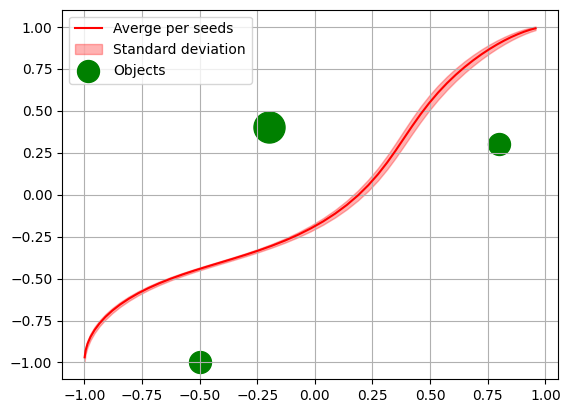

In [ ]:
avg_u = np.mean(uu, axis =2)
plt.plot(avg_u[:,0], avg_u[:,1], 'r', label="Averge per seeds")

std_uu = np.std(uu, axis=2)
#confidence_interval = 3.29053 * std_uu / np.sqrt(100)  # 1.96 corresponds to a 95% confidence interval

plt.fill_between(avg_u[:,0], avg_u[:,1] - std_uu[:,1], avg_u[:,1] + std_uu[:,1], color='r', alpha=0.3, label="Standard deviation")

for xtmp, ytmp, gmtmp in bh_xygm_params:
    plt.scatter(xtmp, ytmp, s=gmtmp * 500, c='g', marker='o')


plt.legend(["Averge per seeds","Standard deviation","Objects"])
plt.grid(True)
plt.show()

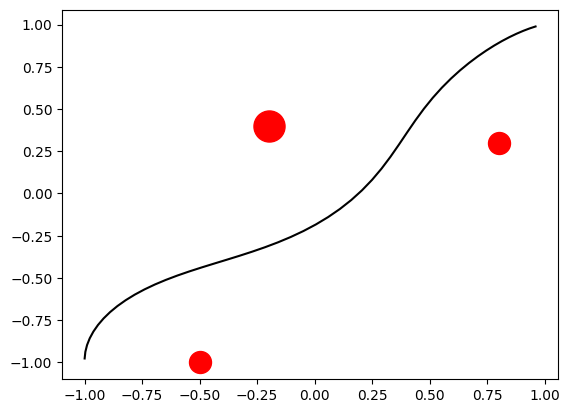

In [ ]:
plt.plot(uu[:, 0,0], uu[:, 1,0], 'k')
for xtmp, ytmp, gmtmp in bh_xygm_params:
    plt.scatter(xtmp, ytmp, s=gmtmp * 500, c='r', marker='o')
plt.show()

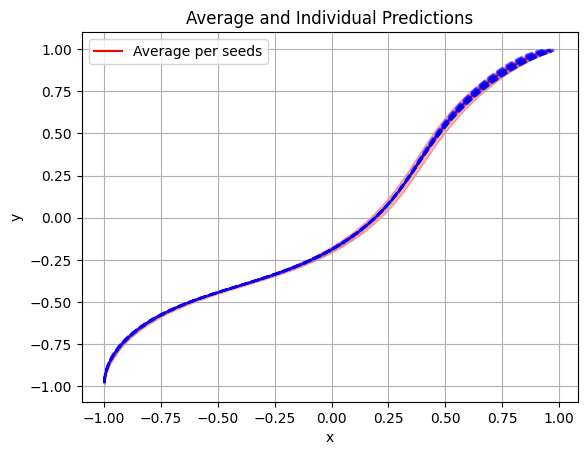

In [ ]:
avg_u = np.mean(uu, axis=2)
std_u = np.std(uu, axis=2)

# Plot average predictions
plt.plot(avg_u[:, 0], avg_u[:, 1], 'r', label="Average per seeds")

# Plot standard deviation as shaded region
plt.fill_between(avg_u[:, 0], avg_u[:, 1] - std_u[:, 1], avg_u[:, 1] + std_u[:, 1], color='r', alpha=0.3)

# Plot individual seed predictions
for seed in range(1, 51):
    plt.plot(uu[:, 0, seed-1], uu[:, 1, seed-1], 'b--', alpha=0.2)

# Set labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Average and Individual Predictions')
plt.legend()
plt.grid(True)
plt.show()